# Characteristics Model
## Setup

In [22]:
import numpy as np
import torch
from torchvision import models
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as T


from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

from train import *
from data_utils import *

%load_ext autoreload
%autoreload 2

FINAL = True

USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

print('use cuda = ', torch.cuda.is_available())
print('using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
use cuda =  True
using device: cuda


In [23]:
## Load the data
# fname = "bolete.h5"
fname = "bolete_lowres.h5"
data = load_bolete_data(fname)

ItemsViewHDF5(<HDF5 file "bolete_lowres.h5" (mode r)>)


In [24]:
# Get Train and Test Split
X_train, X_test, Y_train, Y_test, y_train, y_test = get_train_and_test(data, 'bolete-characteristics')


In [25]:
## Download pretrained model(s)
model = models.googlenet(pretrained=True)
# model = models.resnext101_32x8d(pretrained=True)
# model = models.alexnet(pretrained=True)

## Transfer Learn with cross validation


In [26]:
def loss_fn(scores, true_y):
    probs = torch.sigmoid(scores)
    if_true = true_y * torch.log(probs)
    if_false = (1-true_y) * torch.log(1 - probs)
    loss = -1 * torch.sum(if_true + if_false)
    return loss

def pred_fn(scores):
    outputs = torch.sigmoid(scores)
    preds = outputs > 0.5
    return preds

num_classes = Y_train.shape[1]

for param in model.parameters():
    param.requires_grad = False
 
fc_in_feats = model.fc.in_features
model.fc = nn.Linear(fc_in_feats, num_classes)

# optimizer = optim.Adam(model.fc.parameters(), betas=(.5, .999), lr=1e-2)

optimizer = optim.RMSprop(
    model.parameters(),
    lr=5e-4,
    momentum=0.1,
    alpha=0.99
    )

transform = T.Compose([T.ToTensor()])

batch_size = 128
num_epochs = 40

torch.manual_seed(0)
history = cross_val(
    X_train, 
    Y_train,
    y_train,
    model, 
    optimizer, 
    # nn.MultiLabelSoftMarginLoss(), 
    nn.BCEWithLogitsLoss(),
    pred_fn,
    batch_size = batch_size, 
    num_epochs = num_epochs,
    show_every = 1,
    folds=1,
    test_size=0.2,
    device=device,
    dtype=dtype,
    transform = transform,
)

CV model on:  cuda
CV Fold:  1
Training model on:  cuda
Iter: 0
train Loss: 0.6113 Acc: 25.2731
Iter: 1
val Loss: 0.5702 Acc: 26.8717
Iter: 2
train Loss: 0.5667 Acc: 26.9063
Iter: 3
val Loss: 0.5680 Acc: 26.7380
Iter: 4
train Loss: 0.5598 Acc: 27.1044
Iter: 5
val Loss: 0.5637 Acc: 27.0107
Iter: 6
train Loss: 0.5527 Acc: 27.3387
Iter: 7
val Loss: 0.5629 Acc: 27.0642
Iter: 8
train Loss: 0.5499 Acc: 27.4391
Iter: 9
val Loss: 0.5629 Acc: 26.9091
Iter: 10
train Loss: 0.5445 Acc: 27.4766
Iter: 11
val Loss: 0.5621 Acc: 27.0535
Iter: 12
train Loss: 0.5397 Acc: 27.5448
Iter: 13
val Loss: 0.5615 Acc: 27.2246
Iter: 14
train Loss: 0.5370 Acc: 27.7416
Iter: 15
val Loss: 0.5621 Acc: 26.8984
Iter: 16
train Loss: 0.5335 Acc: 27.8367
Iter: 17
val Loss: 0.5598 Acc: 27.0802
Iter: 18
train Loss: 0.5311 Acc: 27.8795
Iter: 19
val Loss: 0.5595 Acc: 27.1444
Iter: 20
train Loss: 0.5279 Acc: 27.9371
Iter: 21
val Loss: 0.5602 Acc: 27.1230
Iter: 22
train Loss: 0.5248 Acc: 28.0884
Iter: 23
val Loss: 0.5593 Acc: 27

True

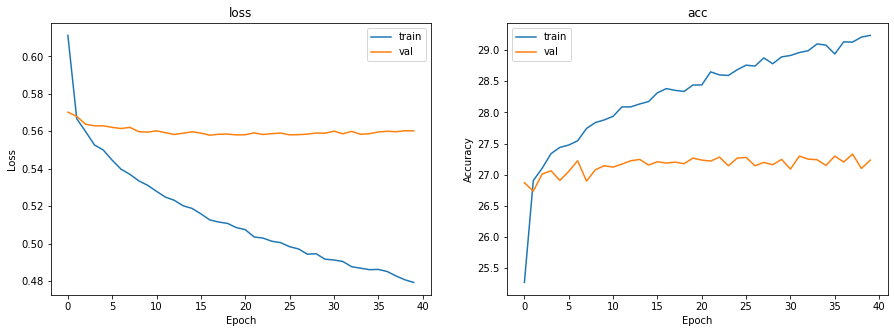

In [27]:
fig, axes = plt.subplots(1, 2, figsize=[15,5], sharex=False, sharey=False)
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Accuracy")

plotnum = 0

phase = ["train", "val"]
for s in ["loss", "acc"]:
    for a in phase:
        axes[plotnum].set_title(s)
        axes[plotnum].set_xlabel("Epoch")
        # for i in range(len(history[a+'_'+s])):
            # axes[plotnum].plot(history[a+'_'+s][i])
        axes[plotnum].plot(np.mean(history[a+'_'+s], axis=0))
        axes[plotnum].legend(phase)
    plotnum += 1

save_history_data(history, "characteristic_"+fname, edibility=False)

## Train on all the data

In [28]:
if FINAL:
    model = models.googlenet(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    fc_in_feats = model.fc.in_features
    model.fc = nn.Linear(fc_in_feats, num_classes)
    
    dataloader_tr = get_loader(X_train, Y_train, batch_size, transform)
    dataloader_val = get_loader(X_test, Y_test, batch_size, transform)
    dataloaders = {"train":dataloader_tr, "val":dataloader_val}
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(
        model,
        optimizer,
        dataloaders,
        loss_fn,
        pred_fn,
        num_epochs,
        show_every=1,
        device=device,
        dtype=dtype,
        phases=["train", "val"],
    )
    history = {
        "train_acc": train_acc_history,
        "train_loss": train_loss_history,
        "val_acc": val_acc_history,
        "val_loss": val_loss_history,
    }
    save_history_data(history, "characteristic_"+fname, edibility=False)

Training model on:  cuda
Iter: 0
train Loss: 3264.0924 Acc: 20.3437
Iter: 1
val Loss: 3249.7698 Acc: 20.3715
Iter: 2
train Loss: 3265.9929 Acc: 20.3704
Iter: 3
val Loss: 3253.8647 Acc: 20.5214
Iter: 4
train Loss: 3264.9413 Acc: 20.4486
Iter: 5
val Loss: 3255.5438 Acc: 20.5749
Iter: 6
train Loss: 3267.6645 Acc: 20.2612
Iter: 7
val Loss: 3256.3837 Acc: 20.6135
Iter: 8
train Loss: 3264.6472 Acc: 20.4261
Iter: 9
val Loss: 3255.7196 Acc: 20.6403
Iter: 10
train Loss: 3266.7589 Acc: 20.3062
Iter: 11
val Loss: 3255.4969 Acc: 20.6478
Iter: 12
train Loss: 3269.0964 Acc: 20.2516
Iter: 13
val Loss: 3256.4909 Acc: 20.6478
Iter: 14
train Loss: 3266.2156 Acc: 20.4133
Iter: 15
val Loss: 3256.3216 Acc: 20.6253
Iter: 16
train Loss: 3265.3513 Acc: 20.3437
Iter: 17
val Loss: 3254.6282 Acc: 20.6499
Iter: 18
train Loss: 3266.3525 Acc: 20.3084
Iter: 19
val Loss: 3255.5859 Acc: 20.6617
Iter: 20
train Loss: 3266.1296 Acc: 20.4475
Iter: 21
val Loss: 3256.1894 Acc: 20.6606
Iter: 22
train Loss: 3264.8435 Acc: 20.

ValueError: If using all scalar values, you must pass an index

## Evaluate 

In [8]:
if FINAL:
    X, Y, y = X_test, Y_test, y_test
else:
    X, Y, y = get_val(X_train, Y_train, y_train)

scores, y_pred, y_true, y_labels = evaluate(
    X,  # images
    Y,  # output
    y,  # labels
    model,
    Y.shape[1],
    pred_fn,
    device=device,
    transform=None,
)
save_raw_eval_data(scores, y_pred, y_true, y_labels, "characteristic_"+fname)

Evaluating model on:  cuda


True